# Describe merged sequences file

Download the `merged_results` folder as described by `README.md` in this project 
root folder. Then we can apply some statistics to the merged sequences file.

In [1]:
import csv

import biom
import Bio.SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src import project_directory

let's read the sequences file:

In [2]:
fasta_file = project_directory / "merged_results/export/rep-seqs.fasta/dna-sequences.fasta"

sequences = Bio.SeqIO.index(fasta_file, "fasta")

How many sequences are in the file?

In [3]:
len(sequences)

171803

## Describe sequence lengths

Let's measure the length of each sequence and plot a histogram of the lengths:

In [4]:
# get the lengths of all sequences
sequence_lengths = [len(record.seq) for record in sequences.values()]

Let's search for outliers in the lengths of the sequences, for example sequences
with lengths 1.5 far from IQR:

In [5]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(sequence_lengths, 25)
Q3 = np.percentile(sequence_lengths, 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = [length for length in sequence_lengths if length < lower_bound or length > upper_bound]

print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")

Lower bound for outliers: 372.0
Upper bound for outliers: 452.0


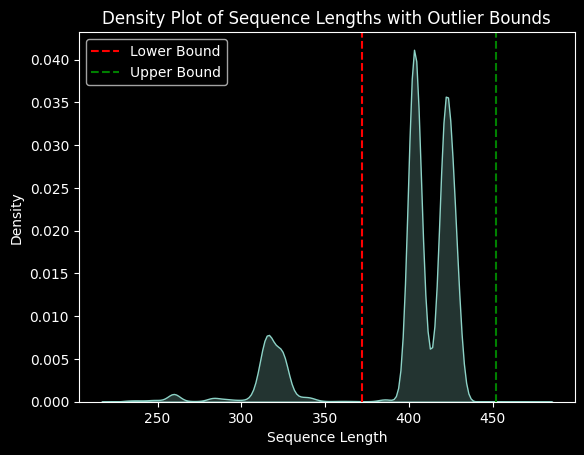

In [6]:
# Create a density plot
sns.kdeplot(sequence_lengths, fill=True)
plt.axvline(lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='g', linestyle='--', label='Upper Bound')
plt.xlabel('Sequence Length')
plt.ylabel('Density')
plt.title('Density Plot of Sequence Lengths with Outlier Bounds')
plt.legend()
plt.show()

In [7]:
num_below_lower_bound = sum(length < lower_bound for length in sequence_lengths)
print(f"Number of sequences with lengths below the lower bound: {num_below_lower_bound}")

Number of sequences with lengths below the lower bound: 28099


try to load the taxononies from file

In [8]:
taxonomy_file = project_directory / "merged_results/export/taxonomy/taxonomy.tsv"

with open(taxonomy_file, 'r') as handle:
    reader = csv.DictReader(handle, delimiter='\t')
    taxonomies = [row for row in reader]

taxonomies = {row['Feature ID']: row["Taxon"] for row in taxonomies}

Ok try to collect the taxonomy for sequences with lengths below `lower_bound`:

In [9]:
short_sequences = {record.id: taxonomies[record.id].split(";")[:-1] for record in sequences.values() if len(record.seq) < lower_bound}

In [10]:
# Convert the short_sequences dictionary into a DataFrame
short_sequences_df = pd.DataFrame.from_dict(short_sequences, orient='index', columns=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Strain'])

# Display the DataFrame
short_sequences_df.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Strain
0000b0dfd1e9fb1b144a521a5d59c29c,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,,,
0001caade39e8c23666cfaefa5b5543c,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,,
0003d909ba4f3a474ff7cff43a878011,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospiraceae NK4A136 group,,
0005f2673d31a2f2196c374dbd9f7468,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,,,
00073fce004de488beba628b39618949,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,,,


In [11]:
# Add a column for sequence length
short_sequences_df['Sequence Length'] = [len(sequences[seq_id].seq) for seq_id in short_sequences_df.index]

# Display the updated DataFrame
short_sequences_df.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Strain,Sequence Length
0000b0dfd1e9fb1b144a521a5d59c29c,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,,,,319
0001caade39e8c23666cfaefa5b5543c,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,,,314
0003d909ba4f3a474ff7cff43a878011,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospiraceae NK4A136 group,,,313
0005f2673d31a2f2196c374dbd9f7468,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,,,,318
00073fce004de488beba628b39618949,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,,,,325


In [12]:
# Replace empty values with 'unknown'
short_sequences_df = short_sequences_df.replace('', 'Unknown')

# Display the updated DataFrame
short_sequences_df.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Strain,Sequence Length
0000b0dfd1e9fb1b144a521a5d59c29c,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,Unknown,Unknown,Unknown,319
0001caade39e8c23666cfaefa5b5543c,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,Unknown,Unknown,314
0003d909ba4f3a474ff7cff43a878011,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospiraceae NK4A136 group,Unknown,Unknown,313
0005f2673d31a2f2196c374dbd9f7468,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,Unknown,Unknown,Unknown,318
00073fce004de488beba628b39618949,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Unknown,Unknown,Unknown,325


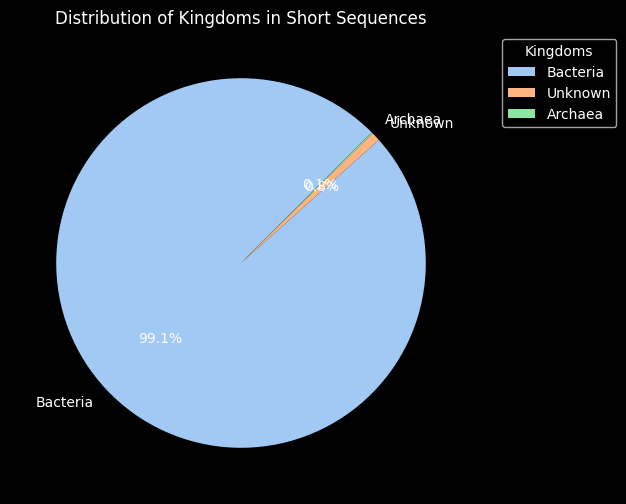

In [13]:
# Count the occurrences of each kingdom
kingdom_counts = short_sequences_df['Kingdom'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10, 6))
kingdom_counts.plot.pie(autopct='%1.1f%%', startangle=45, colors=sns.color_palette('pastel'))
plt.ylabel('')
plt.title('Distribution of Kingdoms in Short Sequences')

# Add a legend
plt.legend(kingdom_counts.index, title="Kingdoms", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


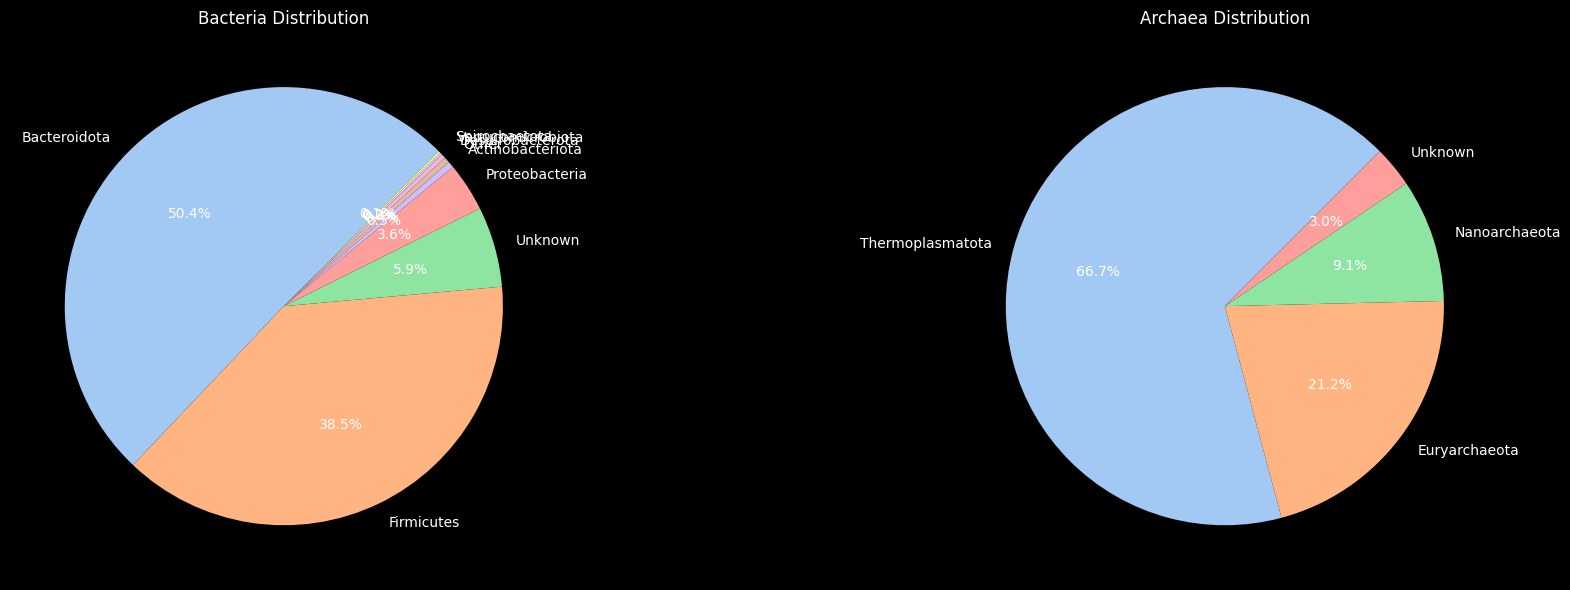

In [14]:
# Count the occurrences of each kingdom
kingdom_counts = short_sequences_df['Kingdom'].value_counts()

# drop the 'Unknown' kingdom
kingdom_counts = kingdom_counts.drop('Unknown')

# Condense values below a certain threshold
threshold = 30

def condense_values(counts, threshold):
    # return if there are a few elements
    if len(counts) <= 5:
        return counts

    # Condense values below a certain threshold
    counts = counts.to_dict()
    other_count = sum(v for v in counts.values() if v <= threshold)
    counts = {k: v for k, v in counts.items() if v > threshold}
    counts['Other'] = other_count
    return pd.Series(counts).sort_values(ascending=False)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(kingdom_counts), figsize=(20, 6))

# Plot each kingdom in a separate subplot
for ax, (kingdom, count) in zip(axes, kingdom_counts.items()):
    kingdom_data = short_sequences_df[short_sequences_df['Kingdom'] == kingdom]
    phylum_counts = kingdom_data['Phylum'].value_counts()
    phylum_counts = condense_values(phylum_counts, threshold)
    phylum_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=45, colors=sns.color_palette('pastel'))
    ax.set_ylabel('')
    ax.set_title(f'{kingdom} Distribution')

# Adjust layout
plt.tight_layout()
plt.show()

## About sample distribution

Are those short sequences prevalent in some samples? load the biom table:

In [15]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [16]:
# get the ids of the short reads
short_read_ids = short_sequences_df.index.tolist()

# Filter the table to include only rows with IDs in short_read_ids
filtered_table = table.filter(short_read_ids, axis='observation', inplace=False)
filtered_table.shape

(28099, 984)

Transform the table into a dataframe:

In [17]:
# Convert the biom table to a pandas DataFrame
filtered_table_df = filtered_table.to_dataframe(dense=True)

# Remove samples (columns) that contain only zeros
filtered_table_df = filtered_table_df.loc[:, (filtered_table_df != 0).any(axis=0)]
filtered_table_df.shape

(28099, 979)

In [18]:
# Sum the counts of short reads for each sample
short_reads_per_sample = filtered_table_df.sum(axis=0)

# Display the result
short_reads_per_sample.head()

H_10_S10_L001    117.0
H_11_S11_L001     74.0
H_12_S12_L001     54.0
H_13_S13_L001     53.0
H_14_S14_L001     41.0
dtype: float64

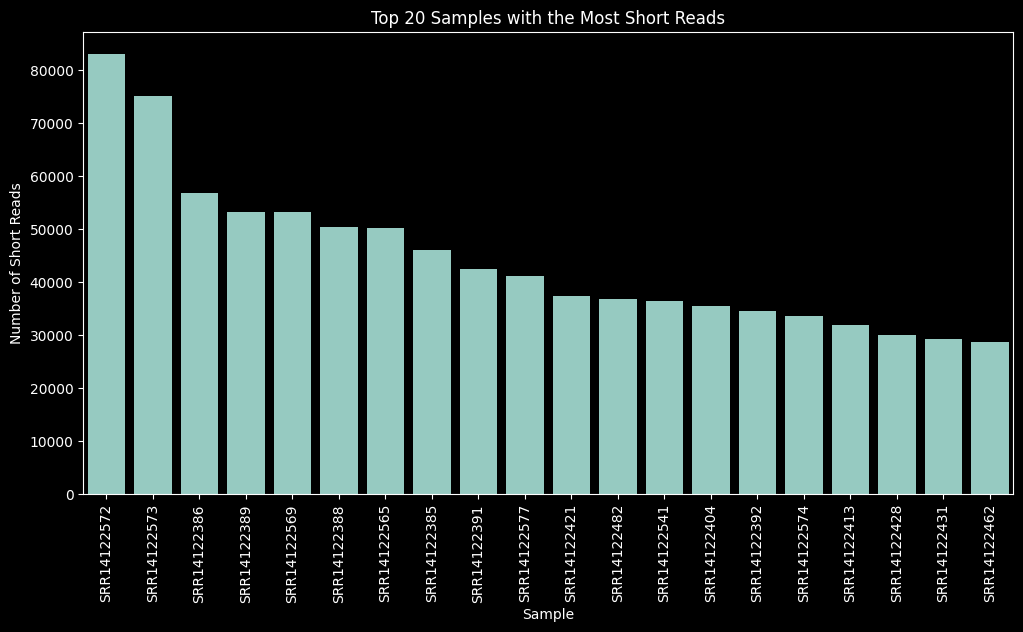

In [19]:
# Plot the short reads per sample for the top 20 samples with the most reads
top_20_samples = short_reads_per_sample.nlargest(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_samples.index, y=top_20_samples.values)
plt.xlabel('Sample')
plt.ylabel('Number of Short Reads')
plt.title('Top 20 Samples with the Most Short Reads')
plt.xticks(rotation=90)
plt.show()

Display the top 20 samples with the most short sequences:

In [20]:
top_20_samples

SRR14122572    83059.0
SRR14122573    75189.0
SRR14122386    56836.0
SRR14122389    53334.0
SRR14122569    53257.0
SRR14122388    50442.0
SRR14122565    50252.0
SRR14122385    46173.0
SRR14122391    42600.0
SRR14122577    41101.0
SRR14122421    37471.0
SRR14122482    36904.0
SRR14122541    36459.0
SRR14122404    35482.0
SRR14122392    34518.0
SRR14122574    33647.0
SRR14122413    31912.0
SRR14122428    29999.0
SRR14122431    29226.0
SRR14122462    28732.0
dtype: float64

Let's collect the total number of counts for sample `ERX12708664`:

In [21]:
counts_ERX12708664 = table.data('ERX12708664', axis='sample').sum()
counts_ERX12708664

np.float64(35864.0)

extract the taxonomy for the shorted sequences in the sample `ERX12708664`:

In [22]:
# Get the sequence IDs for the sample ERX12708664
sample_sequence_ids = filtered_table_df.index[filtered_table_df['ERX12708664'] > 0].tolist()

# Filter the short_sequences_df to include only rows with IDs in sample_sequence_ids
sample_short_sequences_df = short_sequences_df.loc[sample_sequence_ids]

# Display the DataFrame
sample_short_sequences_df.head()


,Kingdom,Phylum,Class,Order,Family,Genus,Species,Strain,Sequence Length
01f91ac4637c14f36c7c59ef58ac05b2,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Mitochondria,Unknown,Unknown,Unknown,283
02a3352999df3e4aacd5ee30dedf8c2a,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,306
0429397003b4eaa95dd9c82fbf3841a2,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Mitochondria,Unknown,Unknown,Unknown,283
0539e3a9971437955467ac1403b28e35,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,367
075e25b01381bbe05d3053ccfa8daa1f,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Mitochondria,Unknown,Unknown,Unknown,283


Display the pie chart of the taxonomy for the shorted sequences in the sample `ERX12708664`:

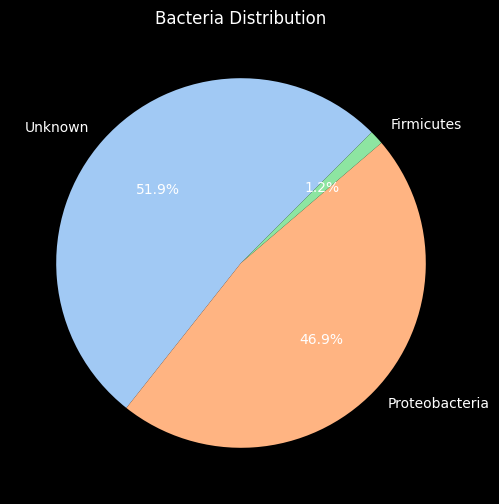

In [23]:
# Count the occurrences of each kingdom
kingdom_counts = sample_short_sequences_df['Kingdom'].value_counts()

# drop the 'Unknown' kingdom
kingdom_counts = kingdom_counts.drop('Unknown')

# Condense values below a certain threshold
threshold = 30

def condense_values(counts, threshold):
    # return if there are a few elements
    if len(counts) <= 5:
        return counts

    # Condense values below a certain threshold
    counts = counts.to_dict()
    other_count = sum(v for v in counts.values() if v <= threshold)
    counts = {k: v for k, v in counts.items() if v > threshold}
    counts['Other'] = other_count
    return pd.Series(counts).sort_values(ascending=False)

# Check the number of kingdoms
if len(kingdom_counts) == 1:
    kingdom = kingdom_counts.index[0]
    kingdom_data = sample_short_sequences_df[sample_short_sequences_df['Kingdom'] == kingdom]
    phylum_counts = kingdom_data['Phylum'].value_counts()
    phylum_counts = condense_values(phylum_counts, threshold)

    # Plot a single pie chart
    plt.figure(figsize=(10, 6))
    phylum_counts.plot.pie(autopct='%1.1f%%', startangle=45, colors=sns.color_palette('pastel'))
    plt.ylabel('')
    plt.title(f'{kingdom} Distribution')
    plt.show()

else:
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(kingdom_counts), figsize=(20, 6))

    # Plot each kingdom in a separate subplot
    for ax, (kingdom, count) in zip(axes, kingdom_counts.items()):
        kingdom_data = sample_short_sequences_df[sample_short_sequences_df['Kingdom'] == kingdom]
        phylum_counts = kingdom_data['Phylum'].value_counts()
        phylum_counts = condense_values(phylum_counts, threshold)
        phylum_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=45, colors=sns.color_palette('pastel'))
        ax.set_ylabel('')
        ax.set_title(f'{kingdom} Distribution')

    # Adjust layout
    plt.tight_layout()
    plt.show()